In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import seaborn as sns
import datetime as dt
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

Problem 1 - Calculate the Value of the Options

Assume you a call and a put option with the following

Current Stock Price $165
Current Date 03/03/2023
Options Expiration Date 03/17/2023
Risk Free Rate of 4.25%
Continuously Compounding Coupon of 0.53%
    
Calculate the time to maturity using calendar days (not trading days).

For a range of implied volatilities between 10% and 80%, plot the value of the call and the put. 

Discuss these graphs. How does the supply and demand affect the implied volatility?

In [1]:
def black_scholes(S0, K, T, r, q, sigma, option):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        price = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Please enter 'call' or 'put'")
    
    return price

In [12]:
S0 = 165 
C = 155 # assumed strike price for call option
P = 175 # assumed strike price for put option
T = (dt.datetime(2023,3,17) - dt.datetime(2023,3,3)).days / 365
r = 0.0425
q = 0.0053
sigma_range = np.linspace(0.1, 0.8, 20)
call_prices = []
put_prices = []
for sigma in sigma_range:
    call_prices.append(black_scholes(S0, C, T, r, q, sigma, option='call'))
    put_prices.append(black_scholes(S0, P, T, r, q, sigma, option='put'))

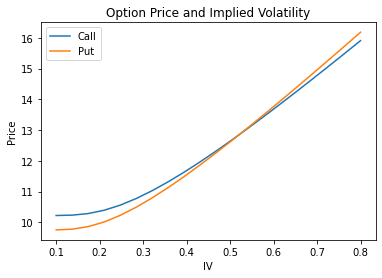

In [13]:
plt.plot(sigma_range, call_prices, label='Call')
plt.plot(sigma_range, put_prices, label='Put')
plt.xlabel('IV')
plt.ylabel('Price')
plt.title('Option Price and Implied Volatility')
plt.legend()
plt.show()

Problem 2 - Calculate the Implied Volatility of the Options for AAPL

Use the options found in AAPL_Options.csv

Current AAPL price is 151.03
Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.
    
Calculate the implied volatility for each option.

Plot the implied volatility vs the strike price for Puts and Calls. 

Discuss the shape of these graphs. What market dynamics could make these graphs?

There are bonus points available on this question based on your discussion. Take some time to research if needed.

In [17]:
AAPL_options = pd.read_csv("Project/AAPL_Options.csv", parse_dates=["Expiration"])

In [19]:
def cal_iv(S0, K, T, r, q, price, option, guess):
    def f(sigma):
        return black_scholes(S0, K, T, r, q, sigma, option) - price
    return brentq(f, guess, 1, xtol=1e-15, rtol=1e-15)

In [20]:
S0 = 151.03
r = 0.0425
q = 0.0053 
current_date = dt.datetime(2023,3,3)

AAPL_options['ImpliedVol'] = 0

for i in range(len(AAPL_options)):
    
    if AAPL_options['Type'][i] == 'Call':
        option_type = 'call'
    else:
        option_type = 'put'
        
    K = AAPL_options['Strike'][i]
    
    T = (AAPL_options['Expiration'][i] - current_date).days / 365
    
    price = AAPL_options['Last Price'][i]
    
    AAPL_options['ImpliedVol'][i] = cal_iv(S0, K, T, r, q, price, option_type, 0.001)
    


/var/folders/mx/h47vz6_d3cj1b2c96lcwngfh0000gn/T/ipykernel_16259/612672447.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_options['ImpliedVol'][i] = cal_iv(S0, K, T, r, q, price, option_type, 0.001)


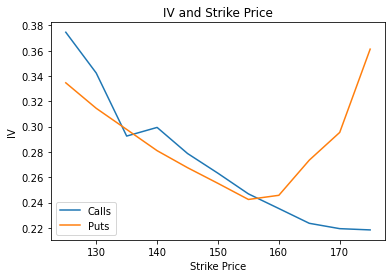

In [22]:
calls = AAPL_options[AAPL_options['Type'] == 'Call']
puts = AAPL_options[AAPL_options['Type'] == 'Put']

plt.plot(calls['Strike'], calls['ImpliedVol'], label='Calls')
plt.plot(puts['Strike'], puts['ImpliedVol'], label='Puts')

plt.xlabel('Strike Price')
plt.ylabel('IV')
plt.title('IV and Strike Price')
plt.legend()
plt.show()

Problem 3 - Calculate the Value of the Options for AAPL
Use the portfolios found in problem3.csv

Current AAPL price is 151.03

Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in the lecture.

In [62]:
portfolios = pd.read_csv('Project/problem3.csv')
portfolios['ExpirationDate'] = pd.to_datetime(portfolios['ExpirationDate'])
S0 = 151.03
r = 0.0425
q = 0.0053
current_date = dt.datetime(2023,3,3)

In [74]:
def cal_portfolio_values(portfolios, underlying_value, S0, r, q, current_date, days_ahead=0):
    portfolio_values = pd.DataFrame(index=portfolios["Portfolio"].unique(), columns=[underlying_value])
    portfolio_values = portfolio_values.fillna(0)
    
    for i, portfolio in portfolios.iterrows():
        
        if portfolio["Type"] == "Stock":
            asset_value = underlying_value
            
        else:
            # For option, calculate values with Black_Scholes Model
            K = portfolio["Strike"]
            T0 = ((portfolio["ExpirationDate"] - current_date).days) / 365
            T = ((portfolio["ExpirationDate"] - current_date).days - days_ahead) / 365
            price = portfolio["CurrentPrice"]
            sigma = cal_iv(S0, K, T0, r, q, price, portfolio.loc['OptionType'].lower(), 0.001)
            option_value = black_scholes(underlying_value, K, T, r, q, sigma, portfolio["OptionType"].lower())
            asset_value = option_value

        # Calculate the total values based on holding
        portfolio_values.loc[portfolio["Portfolio"], :] += portfolio["Holding"] * asset_value

    return portfolio_values

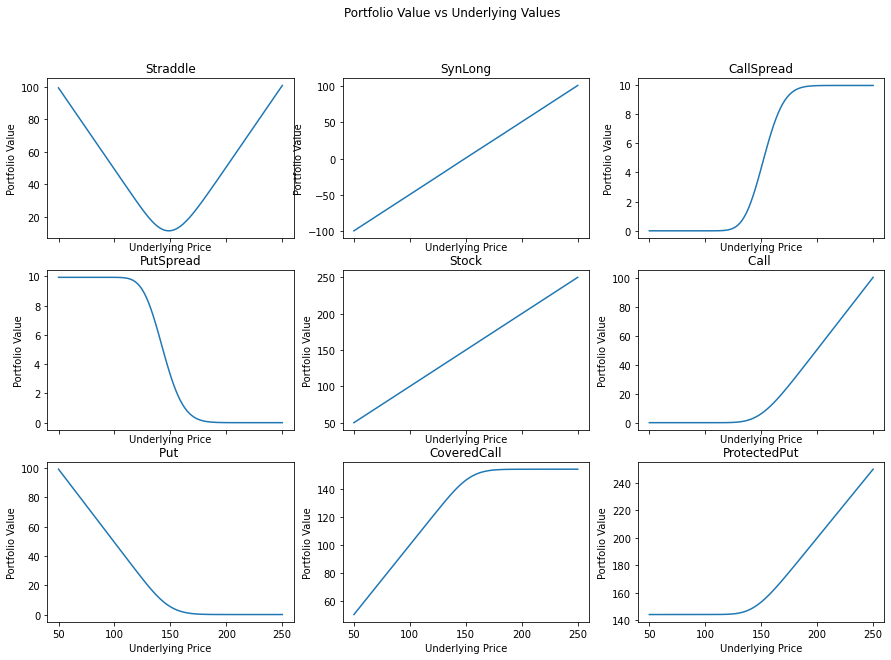

In [82]:
underlying_values = np.linspace(50, 250, 100)
portfolio_values = cal_portfolio_values(portfolios, underlying_values, S0, r, q, current_date)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharex=True)
axs = axs.flatten()

for i, portfolio_1 in enumerate(portfolio_values.index):
    axs[i].plot(underlying_values, portfolio_values.loc[portfolio_1, :])
    axs[i].set_title(portfolio_1)
    axs[i].set_xlabel('Underlying Price')
    axs[i].set_ylabel('Portfolio Value')

plt.suptitle("Portfolio Value vs Underlying Values")
plt.show()

Using DailyPrices.csv. Calculate the log returns of AAPL. Demean the series so there is 0 mean. Fit an AR(1) model to AAPL returns. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above).

Calculate Mean, VaR and ES. Discuss.

Hints:

you will need to calculate the implied volatility - might not be the same as #2

you need to take into account the change in dates for option valuations. 
  You are simulating forward in time and options valuations are a function of time

Calculate the PL from the current portfolio value using Current Date

In [76]:
import quant_risk_mgmt as qrm

In [67]:
price = pd.read_csv('Project/DailyPrices.csv')
aapl_return = pd.DataFrame(qrm.return_calculate(price, 'log')["AAPL"])
aapl_norm = aapl_return - aapl_return.mean()

/Users/wangyuanzhe/Desktop/Y1S2/Fintech545/Week06/quant_risk_mgmt.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


In [77]:
def simulate_price_with_AR1(current_price, returns, n_steps, n_simulation=1000):
    model = ARIMA(returns, order=(1, 0, 0)).fit()
    returns = returns.to_numpy()
    alpha = model.params[1] 
    beta = model.params[0]
    resid = model.resid
    sigma = np.std(resid)
    simulated_returns = np.zeros((n_steps, n_simulation))

    for i in range(n_simulation): 
        simulated_returns[0, i] = beta + alpha * returns[-1] + sigma * np.random.normal() 
        for j in range(1, n_steps):
            simulated_returns[j, i] = beta + alpha * simulated_returns[j-1, i] + sigma * np.random.normal()

    simulated_prices = current_price * np.exp(simulated_returns.cumsum(axis=0))
    
    return simulated_prices

In [83]:
np.random.seed(0)
simulated_prices = pd.DataFrame(simulate_price_with_AR1(S0, aapl_norm, 10))

In [84]:
simulate_portfolio_values = cal_portfolio_values(portfolios, simulated_prices.loc[9:].values[0],S0, r, q, current_date, days_ahead=10)
current_portfolio_values = cal_portfolio_values(portfolios, S0, S0, r, q, current_date)
merged_df = pd.merge(simulate_portfolio_values, current_portfolio_values, left_index=True, right_index=True)
price_change = merged_df.sub(merged_df[S0], axis=0).drop(S0, axis=1)

portfolio_metrics = pd.DataFrame(index=portfolios["Portfolio"].unique(), columns=["Mean", "VaR", "ES"])
portfolio_metrics = portfolio_metrics.fillna(0)

for index, row in price_change.iterrows():
    mean = row.values.mean()
    var = - np.quantile(row.values, 0.05)
    es = -np.mean(row.values[row.values <= -var])
    
    portfolio_metrics.loc[index, "Mean"] = mean
    portfolio_metrics.loc[index, "VaR"] = var
    portfolio_metrics.loc[index, "ES"] = es
    
portfolio_metrics

,Mean,VaR,ES
Straddle,1.326614,1.380597,1.387930
SynLong,-0.424802,16.414656,20.073559
CallSpread,-0.187994,3.910205,4.199130
PutSpread,0.359855,2.553987,2.748505
Stock,-0.223259,16.170964,19.807763
Call,0.450906,6.060526,6.382465
Put,0.875708,4.265698,4.520131
CoveredCall,-0.844624,12.346409,15.870225
ProtectedPut,0.495880,8.112426,8.718021
